# Exploratory Data Analysis - Disc specs dataset

## Objective
Sanity-check this dataset and see what ML tasks are feasible with *specs only* (no throws / no players).

## Setup and Imports

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

import warnings
warnings.filterwarnings('ignore')

## Load and Clean Data

In [2]:
# Load data
data_file = Path('../data/raw/disc-data.csv')

if not data_file.exists():
    raise FileNotFoundError(
        f"Dataset not found at {data_file}. Run `python src/data_loading/download_kaggle_data.py` before executing this notebook."
    )

print(f"Loading {data_file.name}")
df = pd.read_csv(data_file)

print(f"Loaded: {len(df):,} rows x {df.shape[1]} cols")

# Normalize text columns so grouping/counts don't get split 
for col in df.select_dtypes(include="object").columns:
    df[col] = (
        df[col]
        .str.strip()
        .str.replace("\n", " ", regex=False)
        .str.replace("\r", " ", regex=False)
    )


Loading disc-data.csv
Loaded: 1,175 rows x 15 cols


## Initial Data Inspection

In [3]:
print(f"Dataset Shape: {df.shape}")
print(f"Total Disc Models: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print("\nColumn Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

Dataset Shape: (1175, 15)
Total Disc Models: 1,175
Total Features: 15

Column Names:
   1. MOLD
   2. DISC TYPE
   3. SPEED
   4. GLIDE
   5. TURN
   6. FADE
   7. STABILITY
   8. DIAMETER (cm)
   9. HEIGHT (cm)
  10. RIM DEPTH (cm)
  11. RIM WIDTH (cm)
  12. INSIDE RIM DIAMETER (cm)
  13. RIM DEPTH / DIAMETER RATION (%)
  14. RIM CONFIGURATION
  15. BEAD


In [4]:
print("Data Types Summary:")
print(f"  Numeric columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"  String columns: {df.select_dtypes(include=['object']).shape[1]}")
print("\nData Types:")
print(df.dtypes)

Data Types Summary:
  Numeric columns: 12
  String columns: 3

Data Types:
MOLD                                object
DISC TYPE                           object
SPEED                              float64
GLIDE                              float64
TURN                               float64
FADE                               float64
STABILITY                          float64
DIAMETER (cm)                      float64
HEIGHT (cm)                        float64
RIM DEPTH (cm)                     float64
RIM WIDTH (cm)                     float64
INSIDE RIM DIAMETER (cm)           float64
RIM DEPTH / DIAMETER RATION (%)    float64
RIM CONFIGURATION                  float64
BEAD                                object
dtype: object


In [5]:
print("First 5 Disc Models:")
df.head()

First 5 Disc Models:


,MOLD,DISC TYPE,SPEED,GLIDE,TURN,FADE,STABILITY,DIAMETER (cm),HEIGHT (cm),RIM DEPTH (cm),RIM WIDTH (cm),INSIDE RIM DIAMETER (cm),RIM DEPTH / DIAMETER RATION (%),RIM CONFIGURATION,BEAD
0,Armadillo,Putt & Approach,1.0,2.0,0.0,1.0,1.0,21.3,1.9,1.4,0.8,19.6,6.6,90.75,No
1,Beetle,Putt & Approach,1.0,7.0,-1.0,0.0,-1.0,21.9,2.2,1.6,0.8,20.3,7.3,89.25,No
2,Berg,Putt & Approach,1.0,1.0,0.0,2.0,2.0,21.1,2.0,1.4,0.9,19.3,6.6,87.00,No
3,Birdie,Putt & Approach,1.0,2.0,0.0,0.0,0.0,21.2,2.4,1.9,0.7,19.8,9.0,98.25,No
4,Claws,Putt & Approach,1.0,3.0,0.0,0.5,0.5,21.2,2.0,1.7,0.9,19.4,8.0,85.00,No


In [6]:
# Basic statistics
print("Numeric Feature Statistics:")
df.describe()

Numeric Feature Statistics:


,SPEED,GLIDE,TURN,FADE,STABILITY,DIAMETER (cm),HEIGHT (cm),RIM DEPTH (cm),RIM WIDTH (cm),INSIDE RIM DIAMETER (cm),RIM DEPTH / DIAMETER RATION (%),RIM CONFIGURATION
count,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000,1175.000
mean,6.986,4.291,-0.840,2.015,1.174,21.297,1.812,1.260,1.648,17.992,5.916,40.627
std,3.676,1.110,1.122,1.134,1.891,0.331,0.229,0.152,0.481,1.105,0.701,14.468
min,1.000,0.000,-5.000,0.000,-4.000,21.000,1.300,1.100,0.600,15.900,5.000,26.000
25%,4.000,4.000,-1.000,1.000,0.000,21.100,1.700,1.100,1.200,17.100,5.200,29.000
50%,7.000,4.500,-0.500,2.000,1.000,21.200,1.800,1.200,1.700,17.800,5.700,34.000
75%,10.000,5.000,0.000,3.000,2.500,21.400,2.000,1.400,2.000,19.000,6.400,49.750
max,14.500,7.000,2.000,6.000,7.000,24.200,2.900,2.300,2.600,22.800,9.700,98.250


## Data Quality Assessment

### Missing Values Check and Duplicate Detection 

In [7]:
# Check missing values
missing_total = int(df.isna().sum().sum())
if missing_total:
    display(df.isna().sum().sort_values(ascending=False).head(20))

# Find duplicates if any
dupes = int(df.duplicated().sum())
if dupes:
    print(f"Duplicate rows: {dupes}")

### Domain Validation for Disc Golf Standards

In [9]:
RANGES = {
    "SPEED": (1, 15),
    "GLIDE": (1, 7),
    "DIAMETER cm": (20, 25),
}

issues = {}

for col, (lo, hi) in RANGES.items():
    if col not in df.columns:
        continue

    bad = ~df[col].between(lo, hi)
    n_bad = int(bad.sum())

    if n_bad:
        issues[col] = {
            "n_bad": n_bad,
            "bad_min": float(df.loc[bad, col].min()),
            "bad_max": float(df.loc[bad, col].max()),
        }

print("Domain checks:", "OK" if not issues else issues)

# eg. of offending rows
if issues:
    show_cols = ["MOLD"] + [c for c in issues.keys() if c in df.columns]
    display(df.loc[bad.index[bad], show_cols].head(5))


Domain checks: {'GLIDE': {'n_bad': 1, 'bad_min': 0.0, 'bad_max': 0.0}}


,MOLD,GLIDE
269,Baobab,0.0


## Feature Distribution Analysis

In [10]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Analyzing {len(numeric_cols)} numeric features\n")

# Distribution statistics
dist_stats = pd.DataFrame({
    'mean': df[numeric_cols].mean(),
    'median': df[numeric_cols].median(),
    'std': df[numeric_cols].std(),
    'min': df[numeric_cols].min(),
    'max': df[numeric_cols].max(),
    'skewness': df[numeric_cols].skew(),
    'kurtosis': df[numeric_cols].kurtosis()
})

print("Distribution Statistics:")
dist_stats

Analyzing 12 numeric features

Distribution Statistics:


,mean,median,std,min,max,skewness,kurtosis
SPEED,6.986,7.0,3.676,1.0,14.50,0.268,-1.143
GLIDE,4.291,4.5,1.110,0.0,7.00,-0.508,0.033
TURN,-0.840,-0.5,1.122,-5.0,2.00,-1.143,0.932
FADE,2.015,2.0,1.134,0.0,6.00,0.345,-0.288
STABILITY,1.174,1.0,1.891,-4.0,7.00,-0.195,-0.185
DIAMETER (cm),21.297,21.2,0.331,21.0,24.20,3.728,23.816
HEIGHT (cm),1.812,1.8,0.229,1.3,2.90,0.524,0.930
RIM DEPTH (cm),1.260,1.2,0.152,1.1,2.30,1.141,1.929
RIM WIDTH (cm),1.648,1.7,0.481,0.6,2.60,-0.011,-1.234
INSIDE RIM DIAMETER (cm),17.992,17.8,1.105,15.9,22.80,0.144,-0.478


In [15]:
# Identify skewed distributions
def distribution_report(df, numeric_cols, clip_q=(0.005, 0.995)):
    x = df[numeric_cols].copy()

    # Robust copy for skew/kurt (limits extreme-outlier influence)
    x_clip = x.apply(lambda s: s.clip(s.quantile(clip_q[0]), s.quantile(clip_q[1])))

    report = pd.DataFrame({
        "n": x.notna().sum(),
        "missing_pct": x.isna().mean() * 100,
        "mean": x.mean(),
        "median": x.median(),
        "std": x.std(),
        "skew": x_clip.apply(lambda s: skew(s.dropna().to_numpy(), bias=False)),
        "kurtosis": x_clip.apply(lambda s: kurtosis(s.dropna().to_numpy(), fisher=True, bias=False)),
    })

    report["abs_skew"] = report["skew"].abs()
    report["skew_level"] = pd.cut(
        report["abs_skew"],
        bins=[-np.inf, 0.5, 1.0, np.inf],
        labels=["~symmetric", "moderate", "high"],
    )

    return report.sort_values("abs_skew", ascending=False)

dist_report = distribution_report(df, numeric_cols)
display(dist_report)

print("\nTop skewed features:")
print(dist_report.loc[dist_report["skew_level"].isin(["high", "moderate"]), ["skew", "kurtosis", "skew_level"]])

,n,missing_pct,mean,median,std,skew,kurtosis,abs_skew,skew_level
DIAMETER (cm),1175,0.0,21.297,21.2,0.331,3.124,16.505,3.124,high
TURN,1175,0.0,-0.840,-0.5,1.122,-1.111,0.687,1.111,high
RIM CONFIGURATION,1175,0.0,40.627,34.0,14.468,1.059,0.255,1.059,high
RIM DEPTH / DIAMETER RATION (%),1175,0.0,5.916,5.7,0.701,0.910,0.024,0.910,moderate
RIM DEPTH (cm),1175,0.0,1.260,1.2,0.152,0.870,-0.065,0.870,moderate
GLIDE,1175,0.0,4.291,4.5,1.110,-0.487,-0.060,0.487,~symmetric
HEIGHT (cm),1175,0.0,1.812,1.8,0.229,0.426,0.346,0.426,~symmetric
FADE,1175,0.0,2.015,2.0,1.134,0.328,-0.352,0.328,~symmetric
SPEED,1175,0.0,6.986,7.0,3.676,0.264,-1.152,0.264,~symmetric
STABILITY,1175,0.0,1.174,1.0,1.891,-0.205,-0.212,0.205,~symmetric



Top skewed features:
                                  skew  kurtosis skew_level
DIAMETER (cm)                    3.124    16.505       high
TURN                            -1.111     0.687       high
RIM CONFIGURATION                1.059     0.255       high
RIM DEPTH / DIAMETER RATION (%)  0.910     0.024   moderate
RIM DEPTH (cm)                   0.870    -0.065   moderate


Saved z-score violin overview to ..\data\processed\feature_distributions_violin_z_score.png


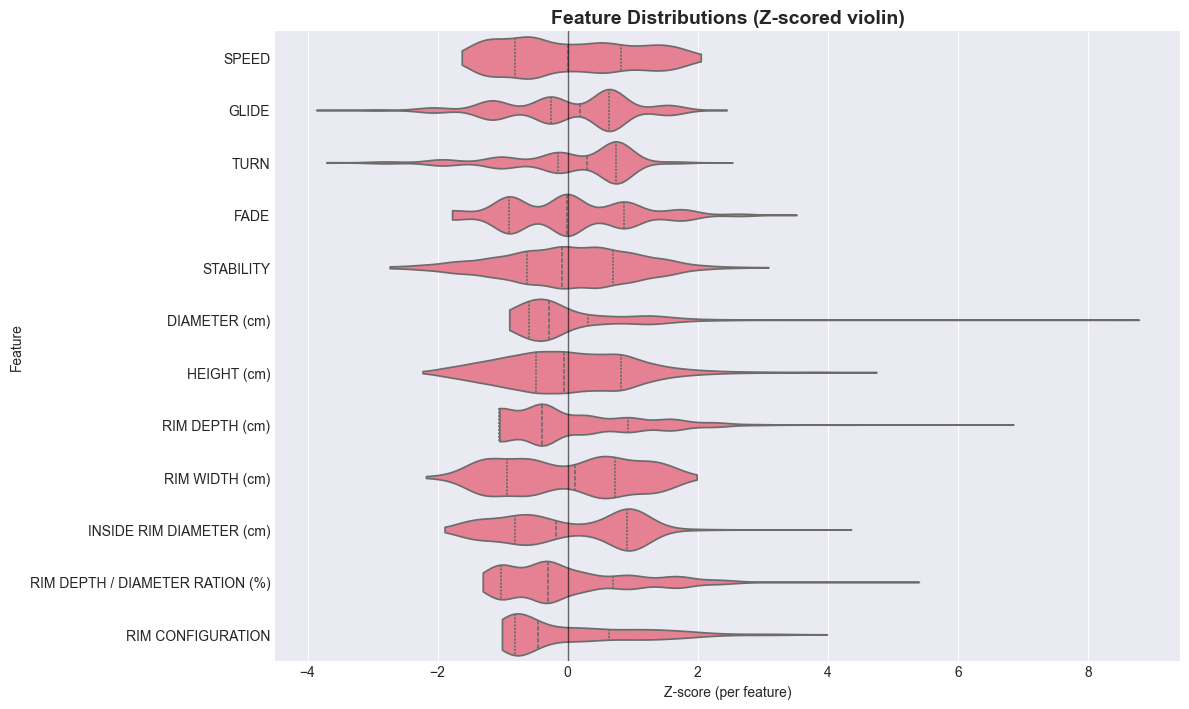

In [17]:
# Visualize numeric feature distributions with violin plots
z = df[numeric_cols].apply(lambda s: (s - s.mean()) / s.std(ddof=0))
melted = z.melt(var_name="feature", value_name="z")

plt.figure(figsize=(12, 0.6 * len(numeric_cols)))

sns.violinplot(data=melted, x="z", y="feature", inner="quartile", cut=0, density_norm="width")
plt.axvline(0, color="black", lw=1, alpha=0.6)
plt.title("Feature Distributions (Z-scored violin)", fontsize=14, fontweight="bold")
plt.xlabel("Z-score (per feature)")
plt.ylabel("Feature")
plt.tight_layout()

out = Path("../data/processed/feature_distributions_violin_z_score.png")
out.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out, dpi=150, bbox_inches="tight")
print(f"Saved z-score violin overview to {out}")
plt.show()

Saved skewed-feature violins to ..\data\processed\skewed_feature_violins_z_score.png


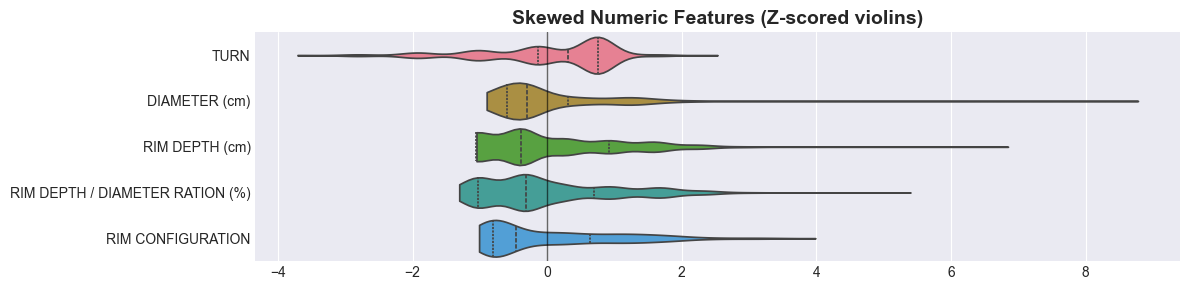

In [20]:
# Violin plots for skewed features
skew_threshold = 0.75
clip_q = (0.005, 0.995)

skewed_columns = []
for col in numeric_cols:
    s = df[col].dropna()
    s_clip = s.clip(s.quantile(clip_q[0]), s.quantile(clip_q[1]))
    if abs(s_clip.skew()) >= skew_threshold:
        skewed_columns.append(col)
        
if skewed_columns:
    z = df[skewed_columns].apply(lambda s: (s - s.mean()) / s.std(ddof=0))

    plt.figure(figsize=(12, 0.6 * len(skewed_columns)))
    sns.violinplot(data=z, orient="h", inner="quartile", cut=0, density_norm="width")
    plt.axvline(0, color="black", lw=1, alpha=0.6)
    plt.title("Skewed Numeric Features (Z-scored violins)", fontsize=14, fontweight="bold")
    plt.tight_layout()

    violin_path = Path("../data/processed/skewed_feature_violins_z_score.png")
    violin_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(violin_path, dpi=150, bbox_inches="tight")
    print(f"Saved skewed-feature violins to {violin_path}")
    plt.show()
else:
    print("No skewed numeric columns exceeded the threshold; violin plot skipped.")

## Categorical Features Analysis

In [21]:
# Analyze categorical features
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

for col in categorical_cols:
    s = df[col].astype("string")
    blank = (s.str.strip() == "").sum()
    nunique = s.nunique(dropna=True)
    ratio = nunique / len(df)

    print(f"\n{col}: unique={nunique}, unique_ratio={ratio:.3f}, blanks={blank}")

    if ratio > 0.2:  # heuristic: too many categories
        print("  High-cardinality (likely identifier-like); skip top-k frequency listing.")
        continue

    vc = s.value_counts(dropna=False)
    print("  Top categories:")
    print(vc.head(10).to_string())


MOLD: unique=1175, unique_ratio=1.000, blanks=0
  High-cardinality (likely identifier-like); skip top-k frequency listing.

DISC TYPE: unique=4, unique_ratio=0.003, blanks=0
  Top categories:
DISC TYPE
Distance Driver    325
Control Driver     301
Putt & Approach    280
Mid Range          269

BEAD: unique=2, unique_ratio=0.002, blanks=0
  Top categories:
BEAD
No     1031
Yes     144


## Correlation Analysis

In [26]:
# Calculate correlation matrices
corr_p = df[numeric_cols].corr(method="pearson")
corr_s = df[numeric_cols].corr(method="spearman")

# Top absolute correlations (excluding diagonal / duplicates)
pairs = (corr_p.abs()
         .where(np.triu(np.ones(corr_p.shape), k=1).astype(bool))
         .stack()
         .sort_values(ascending=False))

print("Top Pearson correlations:")
print(pairs.head(15))

Top Pearson correlations:
RIM DEPTH (cm)                   RIM DEPTH / DIAMETER RATION (%)    0.982
SPEED                            RIM WIDTH (cm)                     0.964
RIM WIDTH (cm)                   INSIDE RIM DIAMETER (cm)           0.951
SPEED                            INSIDE RIM DIAMETER (cm)           0.926
FADE                             STABILITY                          0.839
RIM WIDTH (cm)                   RIM CONFIGURATION                  0.838
TURN                             STABILITY                          0.835
SPEED                            RIM CONFIGURATION                  0.810
RIM DEPTH (cm)                   RIM CONFIGURATION                  0.786
RIM DEPTH / DIAMETER RATION (%)  RIM CONFIGURATION                  0.781
INSIDE RIM DIAMETER (cm)         RIM CONFIGURATION                  0.775
RIM DEPTH (cm)                   RIM WIDTH (cm)                     0.727
SPEED                            RIM DEPTH (cm)                     0.711
RIM WIDTH (c

Saved correlation heatmap to ..\data\processed\correlation_heatmap.png


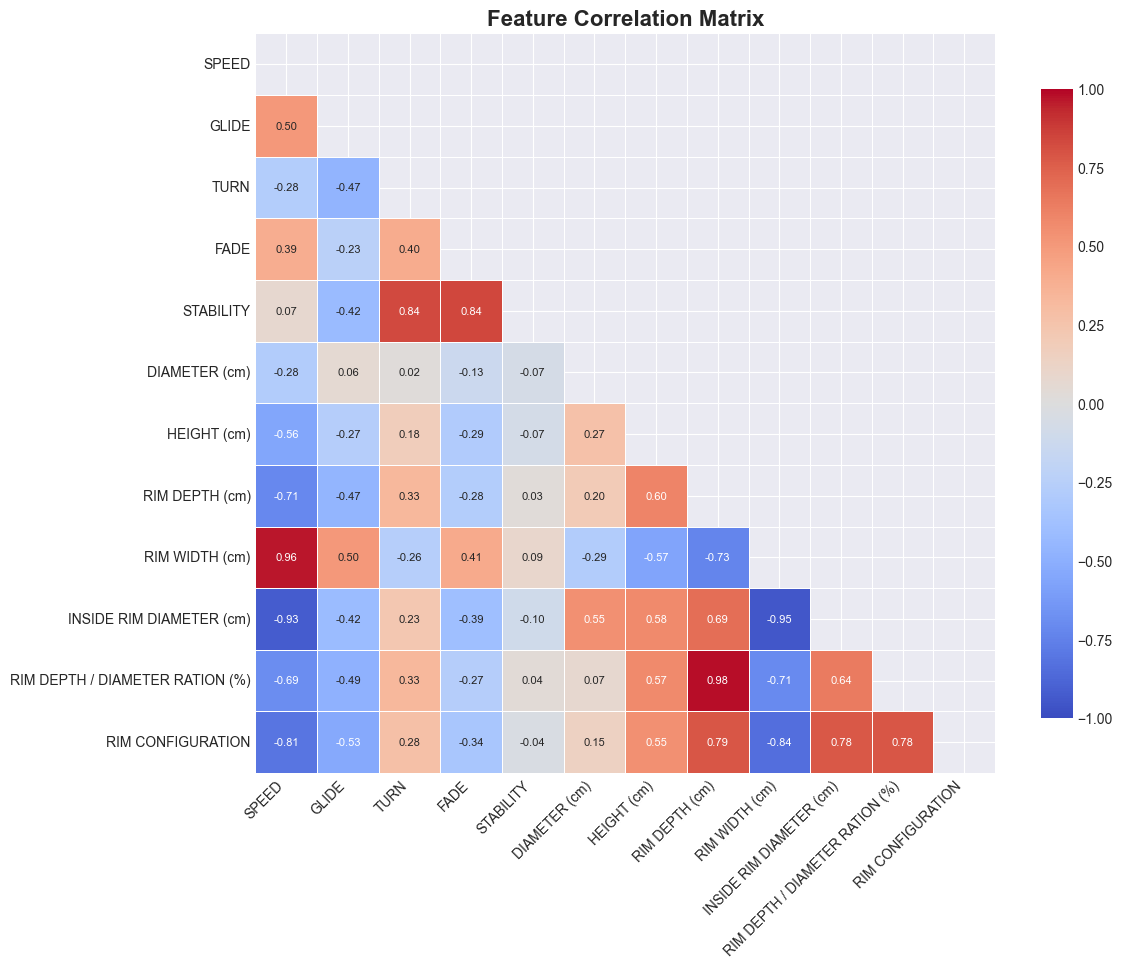

In [29]:
# Create correlation heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap_path = Path("../data/processed/correlation_heatmap.png")

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    annot=True, fmt=".2f",
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
ax.set_title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(Path(heatmap_path), dpi=300, bbox_inches="tight")
print(f"Saved correlation heatmap to {heatmap_path}")
plt.show()

## Disc Type Analysis

Here, we analyze how catalog **specifications** (manufacturer/approved flight numbers and geometry) differ by disc type.

**Important:** As these are not real-throw performance measurements, the results describe spec conventions and design trends, not guaranteed flight outcomes.


In [38]:
# Disc Type Analysis setup
DISC_TYPE_COL = "DISC TYPE"

df = df.copy()
df["DISC_TYPE_CLEAN"] = (
    df[DISC_TYPE_COL]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

preferred_order = ["Putt & Approach", "Mid Range", "Control Driver", "Distance Driver"]
disc_type_order = [t for t in preferred_order if t in df["DISC_TYPE_CLEAN"].unique()]

if len(disc_type_order) == 0:
    disc_type_order = sorted(df["DISC_TYPE_CLEAN"].unique())

print("Disc types:", disc_type_order)
print("Total discs:", len(df))

Disc types: ['Putt & Approach', 'Mid Range', 'Control Driver', 'Distance Driver']
Total discs: 1175


In [40]:
# Disc type distribution
if 'DISC TYPE' in df.columns:
    print("Disc Type Distribution:")
    disc_type_dist = df['DISC TYPE'].value_counts()
    print(disc_type_dist)
    print(f"\nTotal disc types: {df['DISC TYPE'].nunique()}")
else:
    print("DISC TYPE column not found")

Disc Type Distribution:
DISC TYPE
Distance Driver    325
Control Driver     301
Putt & Approach    280
Mid Range          269
Name: count, dtype: int64

Total disc types: 4


In [44]:
# Disc Type summary stats
def iqr(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return s.quantile(0.75) - s.quantile(0.25)

cols_to_summarize = [c for c in (flight_cols + dimension_cols) if c in df.columns]

summary = (
    df.groupby("DISC_TYPE_CLEAN")[cols_to_summarize]
      .agg(["count", "mean", "std", "median", iqr, "min", "max"])
      .reindex(disc_type_order)
)

# Optional: nicer row ordering for display: (stat, feature) rows x disc-type columns
summary_display = summary.T.swaplevel(0, 1).sort_index()
summary_display.rename(index={"iqr": "IQR"}, inplace=True)

summary_display


DISC_TYPE_CLEAN   Putt & Approach  Mid Range  Control Driver  Distance Driver
count  FADE               280.000    269.000         301.000          325.000
       GLIDE              280.000    269.000         301.000          325.000
       SPEED              280.000    269.000         301.000          325.000
       STABILITY          280.000    269.000         301.000          325.000
       TURN               280.000    269.000         301.000          325.000
IQR    FADE                 1.000      2.000           2.000            1.000
       GLIDE                1.000      1.000           1.000            1.000
       SPEED                1.000      1.000           2.000            2.000
       STABILITY            2.000      3.000           2.500            3.000
       TURN                 0.000      1.000           2.000            2.000
max    FADE                 5.000      5.000           6.000            5.000
       GLIDE                7.000      7.000           7.000            6.000
       SPEED                5.000      7.000          11.000           14.500
       STABILITY            6.000      5.000           7.000            6.000
       TURN                 1.000      1.000           2.000            1.000
mean   FADE                 1.436      1.877           2.053            2.592
       GLIDE                3.193      4.322           4.683            4.849
       SPEED                2.541      4.773           7.935           11.766
       STABILITY            1.111      1.160           1.007            1.394
       TURN                -0.325     -0.717          -1.040           -1.198
median FADE                 1.000      2.000           2.000            2.500
       GLIDE                3.000      4.000           5.000            5.000
       SPEED                2.000      5.000           8.000           12.000
       STABILITY            1.000      1.000           1.000            1.500
       TURN                 0.000      0.000          -1.000           -1.000
min    FADE                 0.000      0.000           0.000            1.000
       GLIDE                0.000      1.000           1.000            3.000
       SPEED                1.000      2.000           5.000            8.000
       STABILITY           -4.000     -4.000          -4.000           -4.000
       TURN                -4.000     -5.000          -5.000           -5.000
std    FADE                 1.042      1.188           1.063            0.932
       GLIDE                0.977      1.022           0.886            0.746
       SPEED                0.746      0.653           1.163            1.413
       STABILITY            1.478      2.020           1.998            1.980
       TURN                 0.713      1.128           1.130            1.217

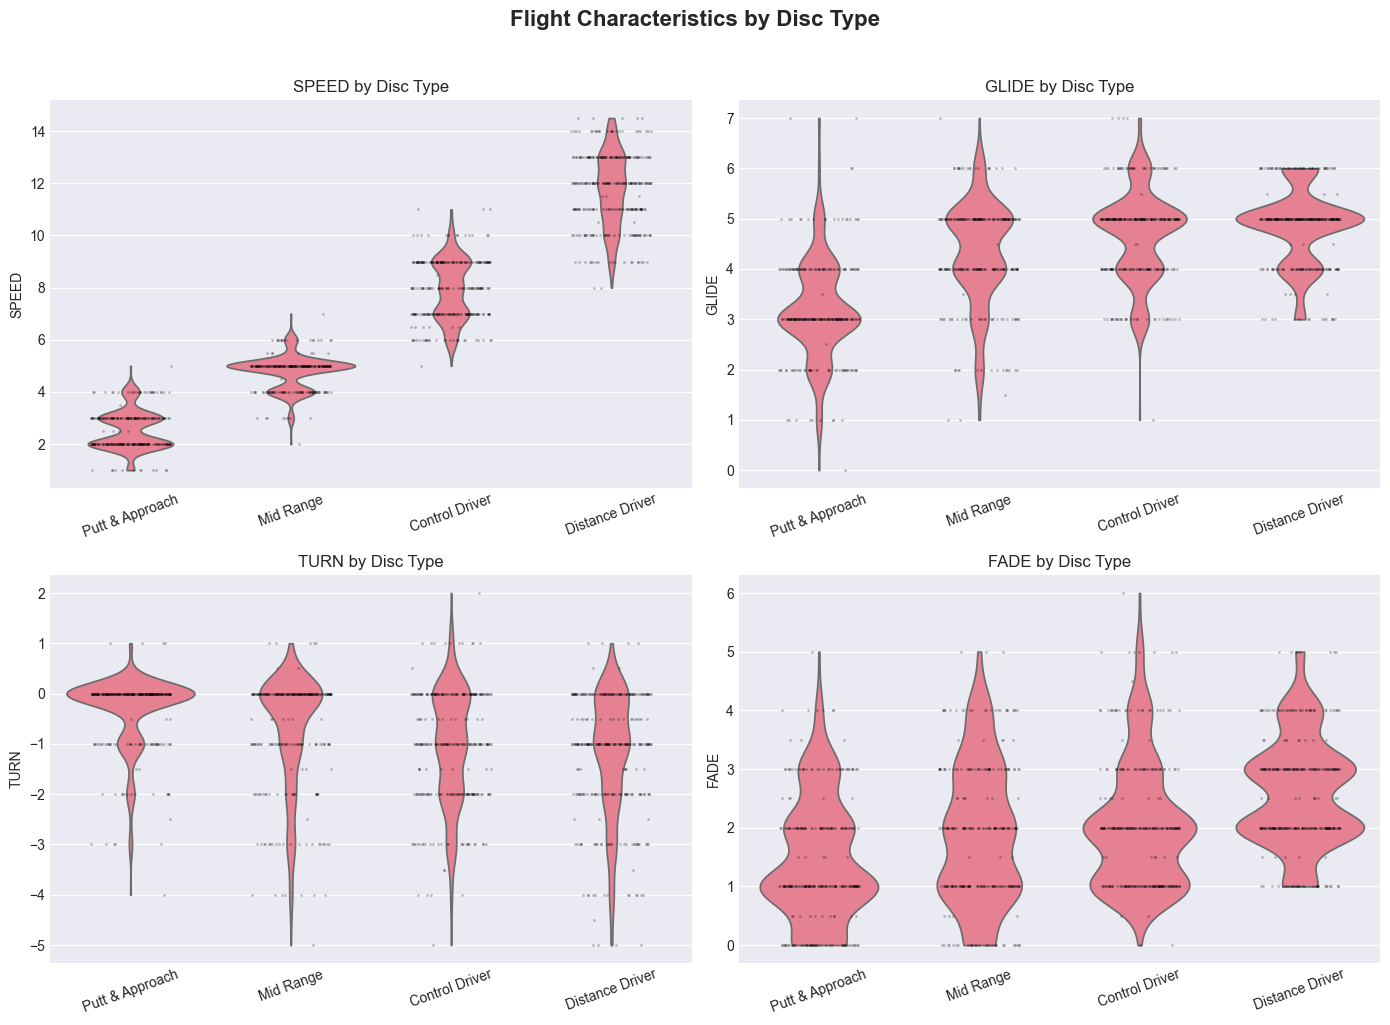

In [ ]:
# Flight numbers by disc type: violin + jittered points (shape + outliers)
plot_cols = [c for c in ["SPEED", "GLIDE", "TURN", "FADE"] if c in df.columns]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, col in zip(axes, plot_cols):
    sns.violinplot(
        data=df, x="DISC_TYPE_CLEAN", y=col,
        order=disc_type_order, inner=None, cut=0, ax=ax
    )
    sns.stripplot(
        data=df, x="DISC_TYPE_CLEAN", y=col,
        order=disc_type_order, color="black", alpha=0.25, size=2,
        jitter=0.25, ax=ax
    )
    ax.set_title(f"{col} by Disc Type")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.tick_params(axis="x", rotation=20)

# Hide unused axes if fewer than 4 plots
for i in range(len(plot_cols), 4):
    fig.delaxes(axes[i])

plt.suptitle("Flight Characteristics by Disc Type", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


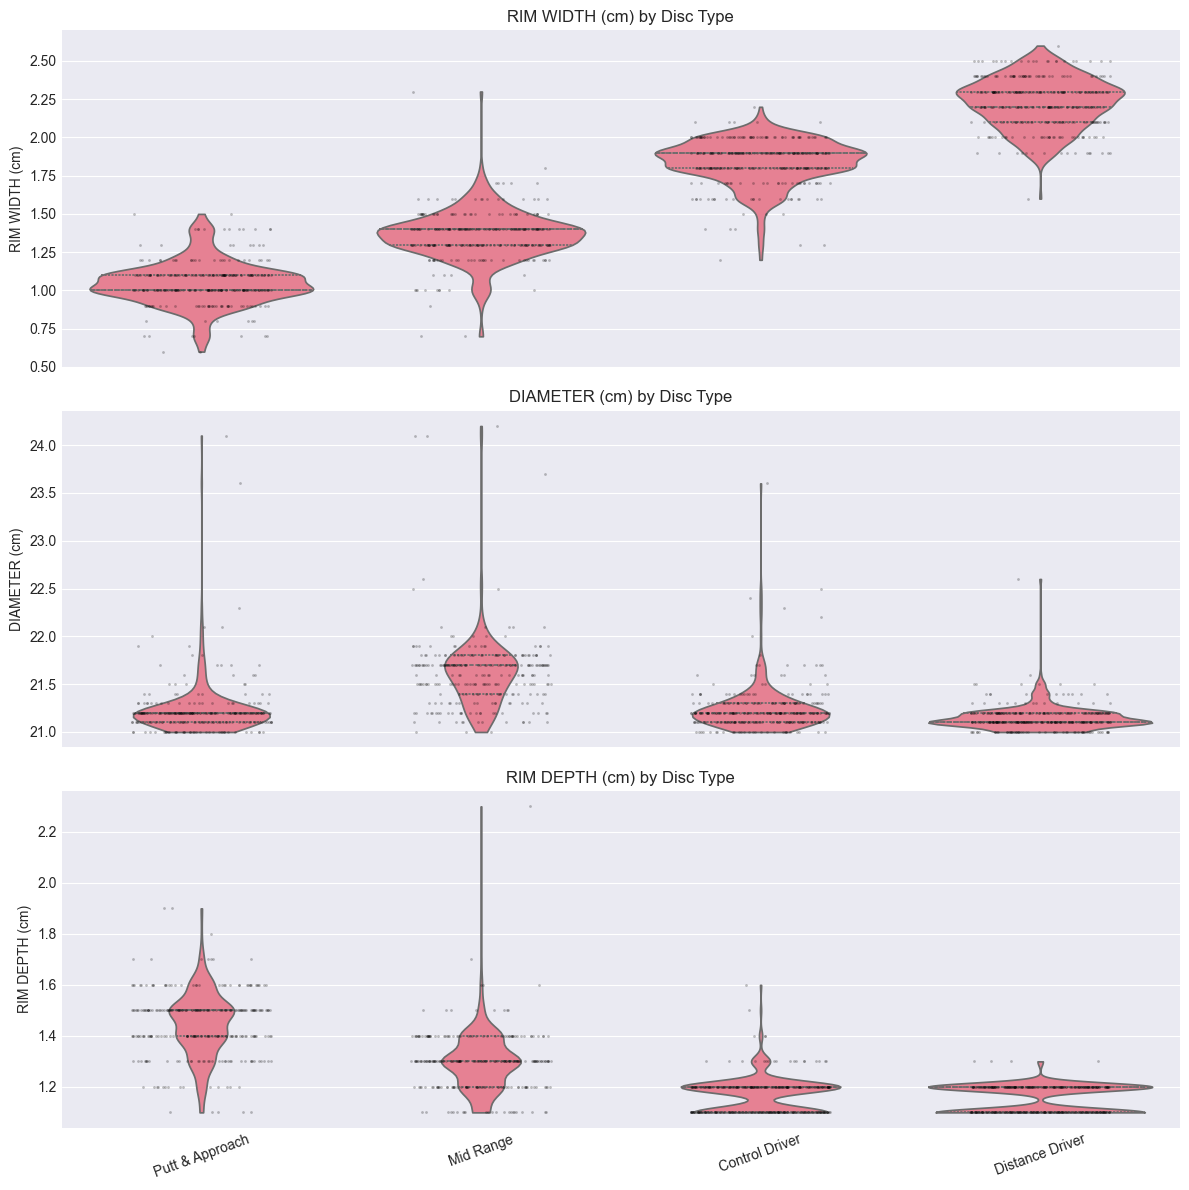

In [57]:
# Key geometry by disc type
def find_col(df_cols, must_contain):
    must_contain = [s.lower() for s in must_contain]
    for c in df_cols:
        cl = str(c).lower()
        if all(s in cl for s in must_contain):
            return c
    return None

rim_width_col = find_col(df.columns, ["rim", "width"])
diameter_col  = find_col(df.columns, ["diameter"])
rim_depth_col = find_col(df.columns, ["rim", "depth"])

geom_cols = [c for c in [rim_width_col, diameter_col, rim_depth_col] if c is not None]

if len(geom_cols) == 0:
    raise ValueError("No geometry columns found (check df.columns after normalization).")

fig, axes = plt.subplots(
    nrows=len(geom_cols),
    ncols=1,
    figsize=(12, 4 * len(geom_cols)),
    sharex=True,
    squeeze=False
)

for i, col in enumerate(geom_cols):
    ax = axes[i, 0]
    sns.violinplot(data=df, x="DISC_TYPE_CLEAN", y=col, order=disc_type_order, inner="quartile", cut=0, ax=ax)
    sns.stripplot(
        data=df,
        x="DISC_TYPE_CLEAN",
        y=col,
        order=disc_type_order,
        color="black",
        alpha=0.25,
        size=2,
        jitter=0.25,
        ax=ax
    )

    ax.set_title(f"{col} by Disc Type")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

## Hypothesis Testing (Proxy Disc Catalog)

**Why this section exists:** The Kaggle dataset is a disc catalog (specs + flight numbers), not throw-level GameProofer data.  
So the goal here is to statistically validate *design/spec conventions* and identify *redundant features* before we:
- Cluster discs into archetypes (Notebook 02) as a proxy for later player-skill clustering.
- Train classification/regression demos (Notebooks 03–04) using clean, non-redundant inputs.

**Interpretation rule:** Significant results here imply differences in *manufacturer-rated specs* by category, not guaranteed in-flight outcomes.

In [66]:
def eta_squared_from_anova(f_stat, df_between, df_within):
    # η² = (F*df_between) / (F*df_between + df_within)
    return (f_stat * df_between) / (f_stat * df_between + df_within)

def cohens_d(x, y):
    x, y = np.asarray(x), np.asarray(y)
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    dof = nx + ny - 2
    pooled = np.sqrt(((nx - 1)*x.var(ddof=1) + (ny - 1)*y.var(ddof=1)) / dof)
    return (x.mean() - y.mean()) / pooled if pooled > 0 else np.nan

def benjamini_hochberg(pvals, alpha=0.05):
    pvals = np.asarray(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    m = len(pvals)
    thresh = alpha * (np.arange(1, m+1) / m)
    passed = ranked <= thresh
    if not passed.any():
        return np.zeros_like(pvals, dtype=bool)
    k = np.max(np.where(passed)[0])
    cutoff = ranked[k]
    return pvals <= cutoff

def summarize_test(name, test, stat, p, effect=None):
    return {
        "hypothesis": name,
        "test": test,
        "stat": stat,
        "p_value": p,
        "effect_size": effect,
    }


In [ ]:
# Tests to confirm hypothesis
COL_SPEED = "SPEED"
COL_RIMW  = "RIM WIDTH (cm)"
COL_RIMD  = "RIM DEPTH (cm)"
COL_TURN  = "TURN"
COL_FADE  = "FADE"
COL_GLIDE = "GLIDE"
COL_TYPE  = "DISC TYPE"
COL_BEAD  = "BEAD"

results = []

# H1: Pearson correlation (Speed vs Rim Width)
x = pd.to_numeric(df[COL_SPEED], errors="coerce")
y = pd.to_numeric(df[COL_RIMW],  errors="coerce")
mask = x.notna() & y.notna()
r, p = stats.pearsonr(x[mask], y[mask])
results.append(summarize_test(
    "H1 Speed ~ Rim Width correlation",
    "Pearson r",
    stat=float(r),
    p=float(p),
    effect=f"r={r:.3f}",
))

# H2: Rim ratio redundancy (compare correlations)
df_test = df.copy()
df_test["rim_ratio"] = pd.to_numeric(df_test[COL_RIMW], errors="coerce") / (pd.to_numeric(df_test[COL_RIMD], errors="coerce") + 1e-6)

pairs = [
    ("rim_ratio vs SPEED", "rim_ratio", COL_SPEED),
    ("rim_ratio vs RIM WIDTH", "rim_ratio", COL_RIMW),
]
for label, a, b in pairs:
    xa = pd.to_numeric(df_test[a], errors="coerce")
    xb = pd.to_numeric(df_test[b], errors="coerce")
    m = xa.notna() & xb.notna()
    rr, pp = stats.pearsonr(xa[m], xb[m])
    results.append(summarize_test(
        f"H2 {label}",
        "Pearson r",
        stat=float(rr),
        p=float(pp),
        effect=f"r={rr:.3f}",
    ))

# H3: Disc type differences (ANOVA; fallback to Kruskal if assumptions are shaky)
flight_cols = [COL_SPEED, COL_GLIDE, COL_TURN, COL_FADE]
types = df[COL_TYPE].dropna().unique()

for col in flight_cols:
    groups = []
    for t in types:
        vals = pd.to_numeric(df.loc[df[COL_TYPE] == t, col], errors="coerce").dropna().values
        if len(vals) > 3:
            groups.append(vals)
    if len(groups) < 2:
        continue

    # One-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    df_between = len(groups) - 1
    df_within = sum(len(g) for g in groups) - len(groups)
    eta2 = eta_squared_from_anova(f_stat, df_between, df_within)

    results.append(summarize_test(
        f"H3 {col} differs by DISC TYPE",
        "One-way ANOVA",
        stat=float(f_stat),
        p=float(p_val),
        effect=f"eta^2={eta2:.3f}",
    ))

# H4: BEAD association with DISC TYPE (chi-square)
if COL_BEAD in df.columns and COL_TYPE in df.columns:
    ctab = pd.crosstab(df[COL_TYPE].fillna("Unknown"), df[COL_BEAD].fillna("Unknown"))
    if ctab.shape[0] > 1 and ctab.shape[1] > 1:
        chi2, p_chi, dof, _ = stats.chi2_contingency(ctab)
        results.append(summarize_test(
            "H4 BEAD associated with DISC TYPE",
            "Chi-square",
            stat=float(chi2),
            p=float(p_chi),
            effect=f"dof={int(dof)}",
        ))

# Multiple-testing correction (BH-FDR)
res_df = pd.DataFrame(results)
res_df["bh_reject_0.05"] = benjamini_hochberg(res_df["p_value"].values, alpha=0.05)

res_df = res_df.sort_values(["bh_reject_0.05", "p_value"], ascending=[False, True]).reset_index(drop=True)

res_table["stat"] = pd.to_numeric(res_table["stat"], errors="coerce")
res_table["p_value"] = pd.to_numeric(res_table["p_value"], errors="coerce")

res_table["stat"] = res_table["stat"].round(4)
res_table["p_value"] = res_table["p_value"].apply(lambda v: float(f"{v:.4g}") if pd.notna(v) else np.nan)

res_table


,hypothesis,test,stat,p_value,effect_size,bh_reject_0.05
0,H1 Speed ~ Rim Width correlation,Pearson r,0.964,0.000e+00,r=0.964,True
1,H2 rim_ratio vs SPEED,Pearson r,0.958,0.000e+00,r=0.958,True
2,H2 rim_ratio vs RIM WIDTH,Pearson r,0.984,0.000e+00,r=0.984,True
3,H3 SPEED differs by DISC TYPE,One-way ANOVA,4296.130,0.000e+00,eta^2=0.917,True
4,H3 GLIDE differs by DISC TYPE,One-way ANOVA,197.026,1.960e-103,eta^2=0.335,True
5,H4 BEAD associated with DISC TYPE,Chi-square,177.723,2.737e-38,dof=3,True
6,H3 FADE differs by DISC TYPE,One-way ANOVA,62.341,2.143e-37,eta^2=0.138,True
7,H3 TURN differs by DISC TYPE,One-way ANOVA,38.306,1.292e-23,eta^2=0.089,True


In [74]:
out_path = Path("data/processed/hypothesis_test_results.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
res_table.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: data\processed\hypothesis_test_results.csv


### Based on Hypothesis Test Results

**H1 - Speed and rim width are strongly correlated (redundant inputs)**<br>
If true, we should **keep one** (usually SPEED for interpretability) and avoid feeding both into clustering/regression without PCA.

**H2 - Derived rim ratio is redundant with speed/rim width**<br>
If true, we should **drop derived rim-ratio features** from the baseline clustering feature set.

**H3 - Flight-number distributions differ by disc type**<br>
If true, DISC TYPE is a meaningful grouping variable (useful for interpretation, stratified evaluation, or as a supervised target in later demos).

**H4 - BEAD is associated with disc type (categorical dependence)**<br>
If true, BEAD can be treated as a categorical design signal (but we should not overinterpret causality).

## Save Cleaned Dataset

In [25]:
# Save cleaned dataset
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'disc_golf_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")
print(f"\nRows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

Cleaned dataset saved to: ..\data\processed\disc_golf_cleaned.csv

Rows: 1,175
Columns: 15


## Next Steps

1. **Data Preparation:** Implement full cleaning pipeline (see `src/preprocessing/clean_data.py`). 
2. **Feature Engineering:** Create derived features for ML models. 
3. **Modeling:** Implement feasible ML solutions: 
   - Content-based disc recommendation system 
   - Regression: predict speed from physical dimensions 
   - Clustering: group discs by characteristics 
4. **Evaluation:** Validate models and document results. 
